# Basis frequencies, initialization, and non-negativity constraint
This tutorial covers several important nuances of fitting the DRT:
1. Selecting basis frequencies (or, equivalently, basis time constants)
1. Choosing whether or not to enforce a non-negativity constraint
1. Adjusting model initialization

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook
from copy import deepcopy
import glob

from bayes_drt.inversion import Inverter
import bayes_drt.file_load as fl
import bayes_drt.plotting as bp

%load_ext autoreload
%autoreload 2

In [2]:
# set plotting params
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

# 1. Selecting basis frequencies

The basis frequencies (or time constants) are the frequencies (time constants) at which the basis functions that make up the DRT are located. The basis frequencies need to (1) be spaced appropriately and (2) cover the entire frequency range over which electrochemical relaxations are active. For the calibrated hierarchical Bayesian model implemented in `bayes_drt`, the first criterion is met by simply choosing a spacing of 10 points per decade. The second criterion depends on the data: if all relaxations (arcs or semicircles in the Nyquist plane) are fully captured in the measured frequency range, then using basis frequencies that extend from the highest measured frequency to the lowest is appropriate. However, if there are partially captured relaxations near the measurement boundaries (i.e. $Z^{\prime\prime} \neq 0$ or $Z^\prime$ is changing at the highest and/or lowest measured frequency), the basis frequency range needs to extend beyond the measured frequency range to capture these relaxations.

**By default, an `Inverter` instance will select basis frequencies that extend one decade beyond the measured frequencies in each direction with a spacing of 10 points per decade. Sometimes this is unnecessary; in these cases, shortening the basis frequency range can decrease runtime and improve convergence. Other times, the wider basis frequency range is necessary (as described above), and using a shorter range will result in poor fits of the data.** These scenarios are illustrated below with two sample datasets.


## 1a. Case 1 - extended basis unnecessary

For this example, we use impedance simulated from a circuit consisting of a ZARC element in series with an ohmic resistance.

<IPython.core.display.Javascript object>


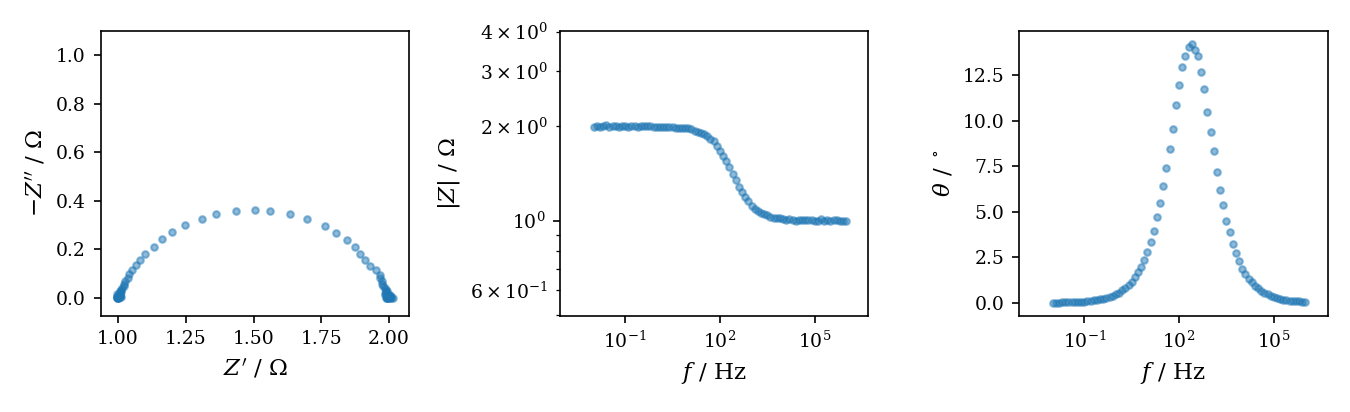

In [111]:
# Load simulated data
circuit = 'ZARC'
err_model = 'Macdonald'
noise_level = 0.25
df_sim = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circuit}_{err_model}_{noise_level}.csv'))

# get measured frequencies and impedance
freq_sim, Z_sim = fl.get_fZ(df_sim)

# load true DRT
g_true = pd.read_csv(os.path.join(datadir,'simulated',f'gamma_{circuit}.csv'))

# plot the simulated impedance data
axes = bp.plot_eis(df_sim)

Examining the Bode plots of the simulated data above, we can see that all relaxations are fully captured within the measurement. Thus, the default extended basis frequency range should be unnecessary. Below, the results for the default basis frequency range are compared to those for a shorter basis frequency range.

Fit time (default basis): 4.35 s
Basis frequency range: 1.0e+07 - 1.0e-03 Hz
Basis tau range: 1.6e-08 - 1.6e+02 s


<IPython.core.display.Javascript object>


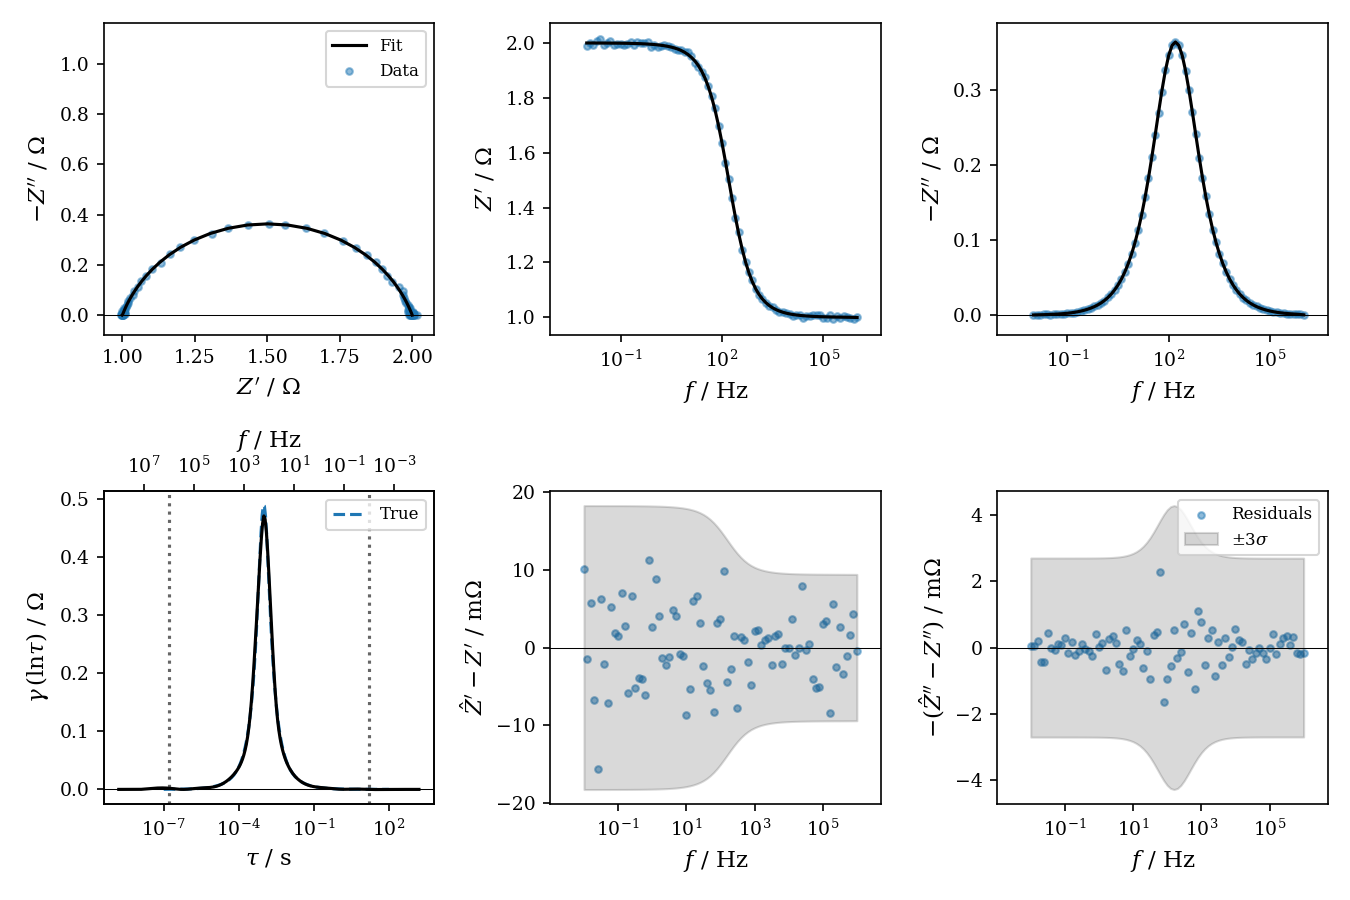

In [112]:
# Use default basis frequencies
inv_sim = Inverter()

# Perform MAP fit
start = time.time()
inv_sim.fit(freq_sim, Z_sim)
print('Fit time (default basis): {:.2f} s'.format(time.time() - start))

# Display basis range
basis_tau = inv_sim.distributions['DRT']['tau']
basis_freq = 1 / (2 * np.pi * basis_tau)
print('Basis frequency range: {:.1e} - {:.1e} Hz'.format(np.max(basis_freq), np.min(basis_freq)))
print('Basis tau range: {:.1e} - {:.1e} s'.format(np.min(basis_tau), np.max(basis_tau)))

# Plot results
axes = inv_sim.plot_full_results()

# Plot true DRT
axes[1, 0].plot(g_true['tau'], g_true['gamma'], ls='--', label='True', zorder=-10)
axes[1, 0].legend()

Fit time (custom basis): 3.87 s
Basis frequency range: 1.0e+06 - 1.0e-02 Hz
Basis tau range: 1.6e-07 - 1.6e+01 s


<IPython.core.display.Javascript object>


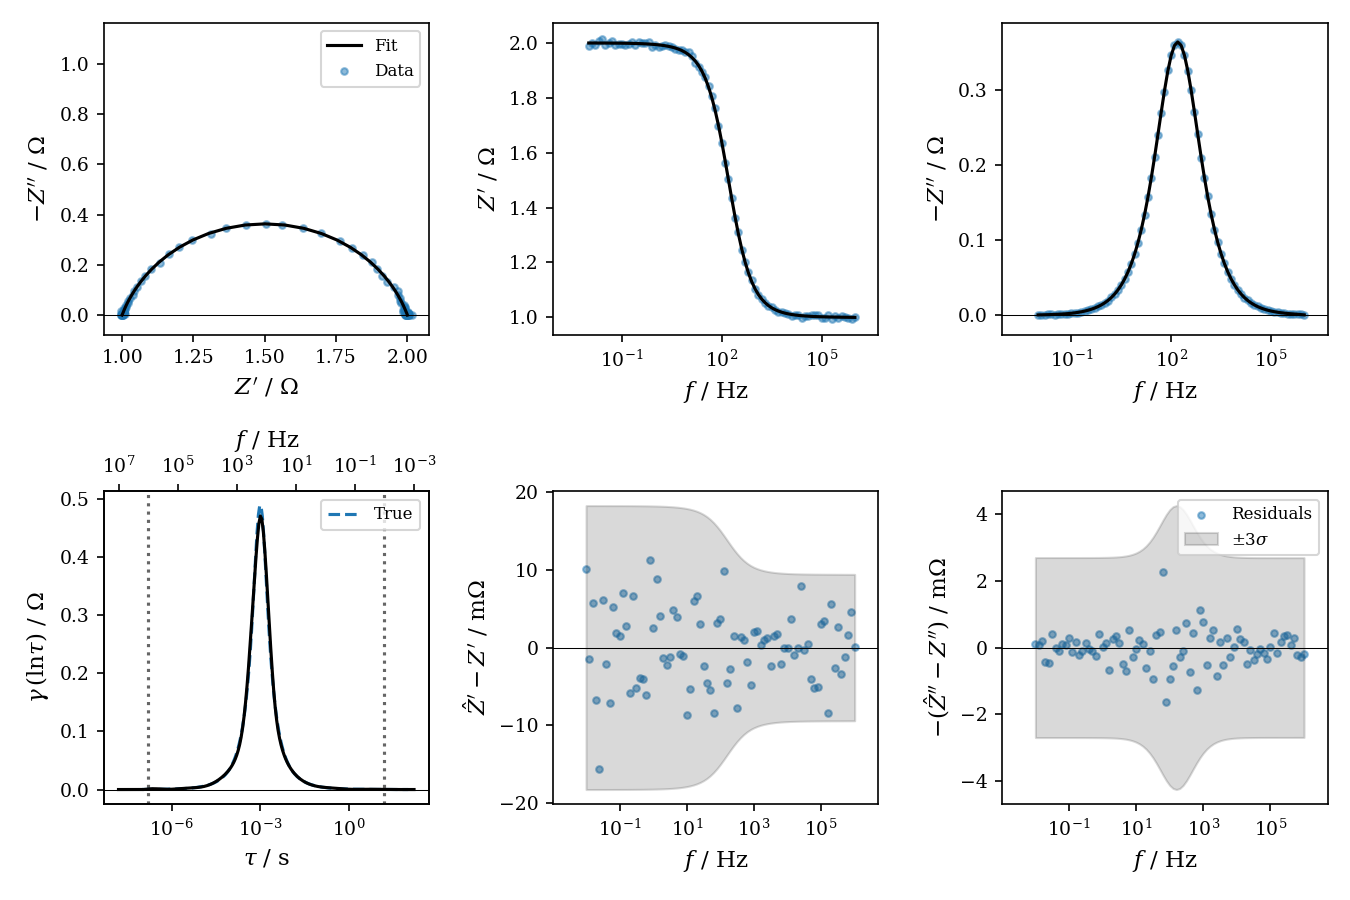

In [113]:
# Set basis frequencies to measurement frequencies
# This can also be done for an existing instance: inv_sim.basis_freq = freq_sim
inv_sim = Inverter(basis_freq=freq_sim)

# Perform MAP fit
start = time.time()
inv_sim.fit(freq_sim, Z_sim)
print('Fit time (custom basis): {:.2f} s'.format(time.time() - start))

# Display basis range
basis_tau = inv_sim.distributions['DRT']['tau']
basis_freq = 1 / (2 * np.pi * basis_tau)
print('Basis frequency range: {:.1e} - {:.1e} Hz'.format(np.max(basis_freq), np.min(basis_freq)))
print('Basis tau range: {:.1e} - {:.1e} s'.format(np.min(basis_tau), np.max(basis_tau)))

# Plot results
axes = inv_sim.plot_full_results()

# Plot true DRT
axes[1, 0].plot(g_true['tau'], g_true['gamma'], ls='--', label='True', zorder=-10)
axes[1, 0].legend()

The results for both fits are nearly identical, indicating that the shortened basis frequency range is appropriate. In addition, the fit with the shortened range runs ~20% faster.

## 1b. Case 2 - extended basis necessary

For this example, we use experimental data collected from a thin film sample.

c:\users\jdh10\onedrive - colorado school of mines\python\projects\bayes_drt\bayes_drt\file_load.py:140: UserWarning: Reading timestamp failed for file ../data\experimental\PDAC_COM3_02109_Contact10_2065C_500C.txt
  warnings.warn(f'Reading timestamp failed for file {file}')


<IPython.core.display.Javascript object>


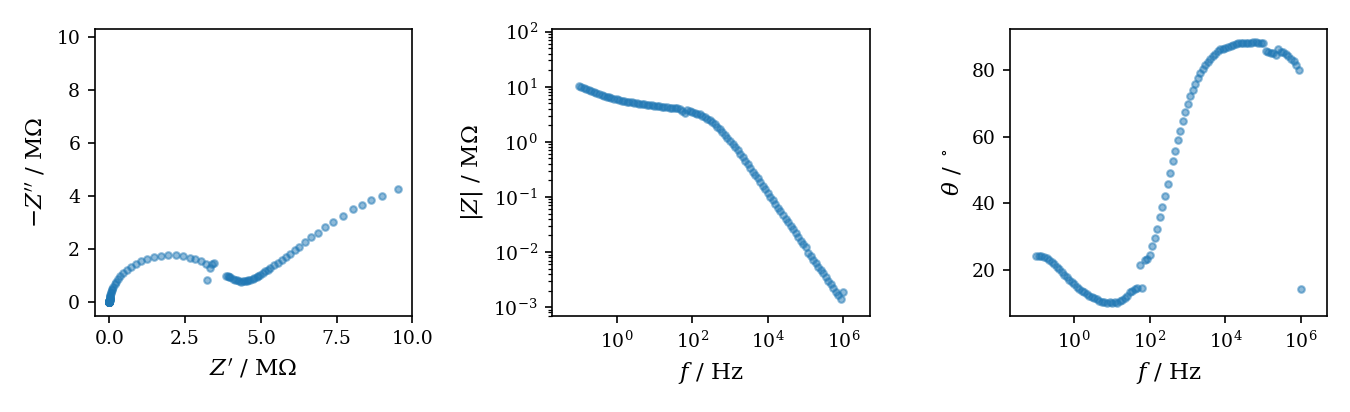

In [119]:
# Load 2nd experimental dataset
df_exp = fl.read_eis(os.path.join(datadir, 'experimental', 'PDAC_COM3_02109_Contact10_2065C_500C.txt'))

# Extract frequencies and impedance
freq_exp, Z_exp = fl.get_fZ(df_exp)

# Plot experimental data
axes = bp.plot_eis(df_exp)

From the Nyquist and Bode plots above, we can see that the low-frequency arc is not fully captured in the measurement. Thus, using an extended basis (at least on the low-frequency end) is necessary; using a basis that extends only as far as the measurement frequencies will cause the DRT to be truncated.

Fit time (default basis): 12.64 s
Basis frequency range: 1.0e+07 - 1.0e-02 Hz
Basis tau range: 1.6e-08 - 1.6e+01 s


c:\users\jdh10\onedrive - colorado school of mines\python\projects\bayes_drt\bayes_drt\inversion.py:1289: UserWarning: Possible outliers were identified at indices [[63]
 [64]], f=[[62.91946]
 [53.87931]] Hz. Check the residuals and consider re-running with outliers=True
  outlier_idx, frequencies[outlier_idx]))


<IPython.core.display.Javascript object>


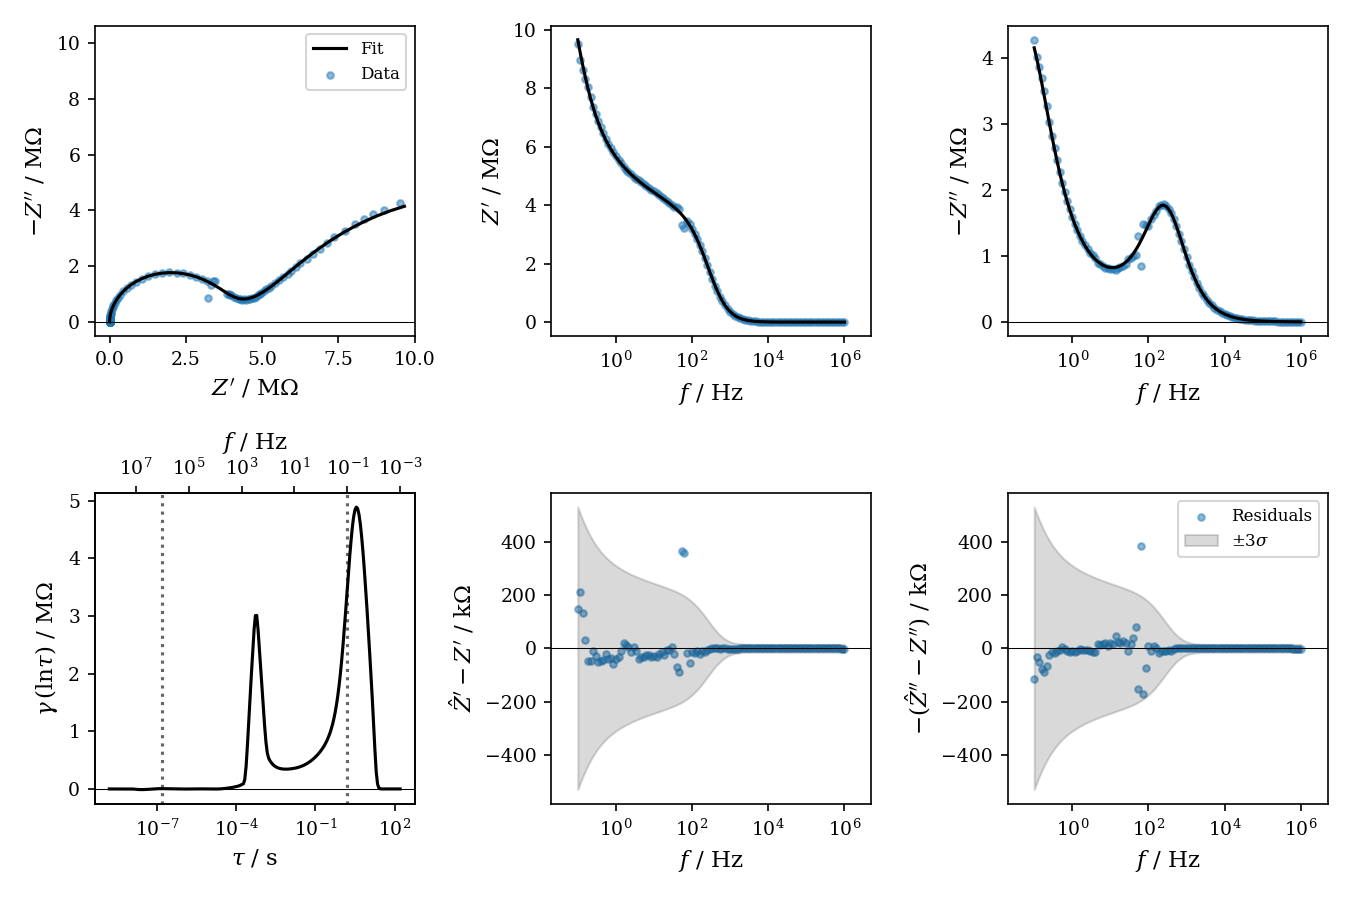

In [120]:
# Use default (extended) basis
inv_exp = Inverter()

# Perform MAP fit
start = time.time()
inv_exp.fit(freq_exp, Z_exp)
print('Fit time (default basis): {:.2f} s'.format(time.time() - start))

# Display basis range
basis_tau = inv_exp.distributions['DRT']['tau']
basis_freq = 1 / (2 * np.pi * basis_tau)
print('Basis frequency range: {:.1e} - {:.1e} Hz'.format(np.max(basis_freq), np.min(basis_freq)))
print('Basis tau range: {:.1e} - {:.1e} s'.format(np.min(basis_tau), np.max(basis_tau)))

# Plot results
axes = inv_exp.plot_full_results()

With the extended basis, we get a reasonably good fit of the data across the entire frequency range. **Note that there are two clearly corrupted data points near 60 Hz, which results in an inflated estimate of the error structure and thus a larger degree of misfit than appropriate. The `Inverter` instance warns us about these outliers; this detection system can be employed to automatically trigger the use of an outlier-robust error model when necessary. See the Outliers tutorial for more detail.**

Fit time (default basis): 18.16 s
Basis frequency range: 1.0e+06 - 1.0e-01 Hz
Basis tau range: 1.6e-07 - 1.6e+00 s


c:\users\jdh10\onedrive - colorado school of mines\python\projects\bayes_drt\bayes_drt\inversion.py:1289: UserWarning: Possible outliers were identified at indices [[63]
 [64]], f=[[62.91946]
 [53.87931]] Hz. Check the residuals and consider re-running with outliers=True
  outlier_idx, frequencies[outlier_idx]))


<IPython.core.display.Javascript object>


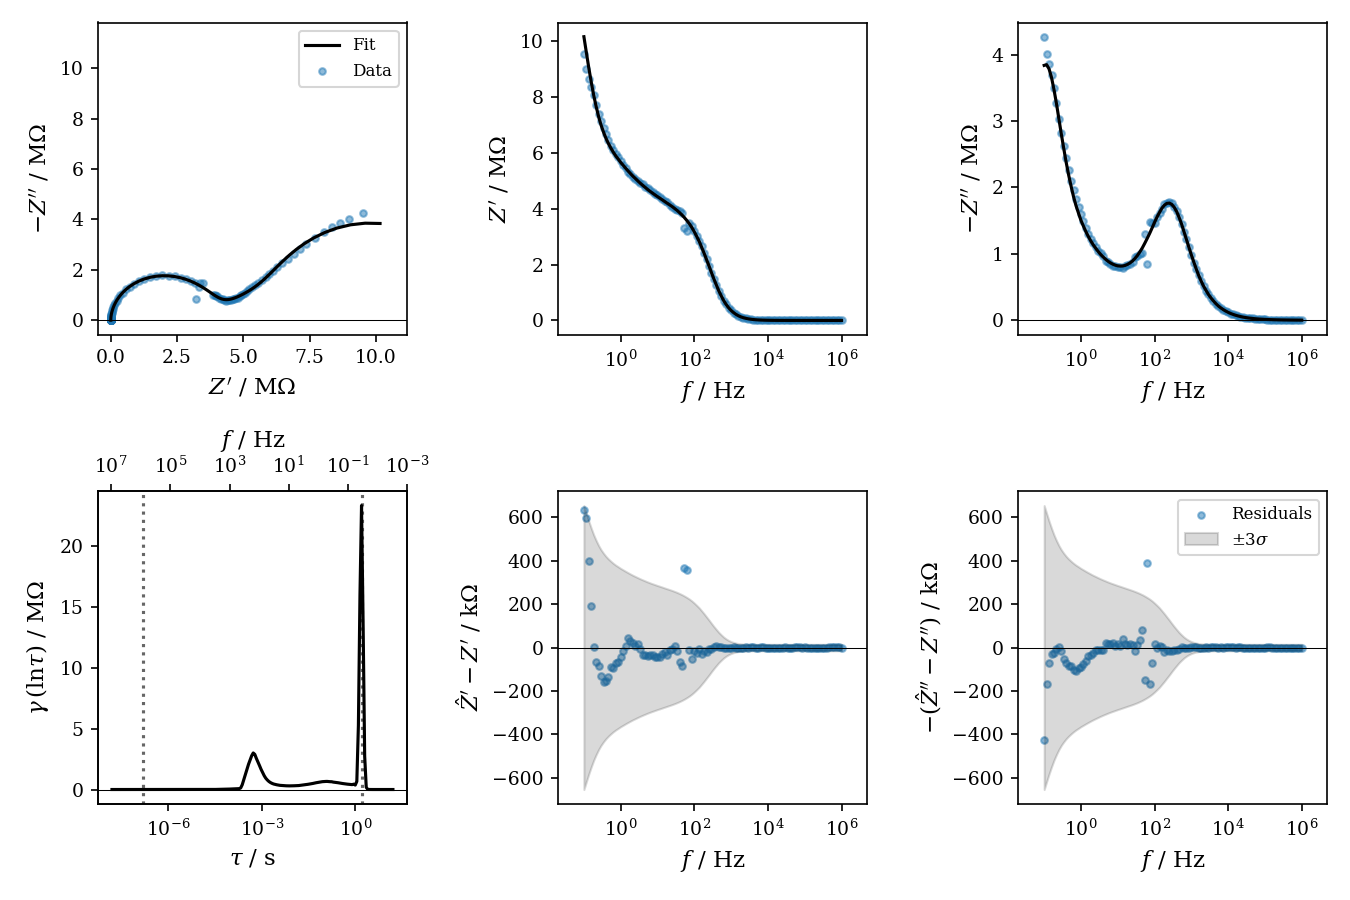

In [121]:
# Use shortened basis (measured frequencies)
inv_exp = Inverter(basis_freq=freq_exp)

# Perform MAP fit
start = time.time()
inv_exp.fit(freq_exp, Z_exp)
print('Fit time (default basis): {:.2f} s'.format(time.time() - start))

# Display basis range
basis_tau = inv_exp.distributions['DRT']['tau']
basis_freq = 1 / (2 * np.pi * basis_tau)
print('Basis frequency range: {:.1e} - {:.1e} Hz'.format(np.max(basis_freq), np.min(basis_freq)))
print('Basis tau range: {:.1e} - {:.1e} s'.format(np.min(basis_tau), np.max(basis_tau)))

# Plot results
axes = inv_exp.plot_full_results()

With the shortened basis, the misfit of the low-frequency data is much more severe. The DRT also shows an anomalously sharp peak at the lowest basis frequency/longest basis timescale - this is because the longer basis timescales which are necessary to fit the data are not available. Thus, for this spectrum, the default extended basis frequency range is necessary to obtain a good fit of the data.

# 2. Non-negativity constraint
By default, `fit` does not constrain the sign of the DRT. This is the default behavior for a few reasons: (1) the model is typically robust to extraneous zero crossings, (2) allowing negative coefficients allows sharper peaks to be recovered, and (3) implementing a hard bound at zero can occasionally cause undesirable behavior in the optimization algorithm. **However, you may want to constrain the DRT to non-negative values by specifying `nonneg=True` if you know that the DRT is non-negative AND one of the following is true:**
1. **You observe false negative peaks without the non-negativity constraint**
1. **You want faster results**


Negative peaks in the DRT do have a physical meaning - they correspond to so-called "inductive loops" in impedance spectra, i.e. semicircles that appear below the x-axis in a Nyquist plot. These features can appear in batteries, fuel cells, and other sample types under certain measurement conditions.

In the subsections below, the non-negativity constraint is demonstrated for (a) a purely non-negative DRT and (b) a DRT with positive and negative peaks.

## 2a. Purely non-negative DRT

For this example we use a spectrum simulated from an equivalent circuit consisting of a ZARC element in series with an RC element. The true DRT is purely non-negative.

<IPython.core.display.Javascript object>


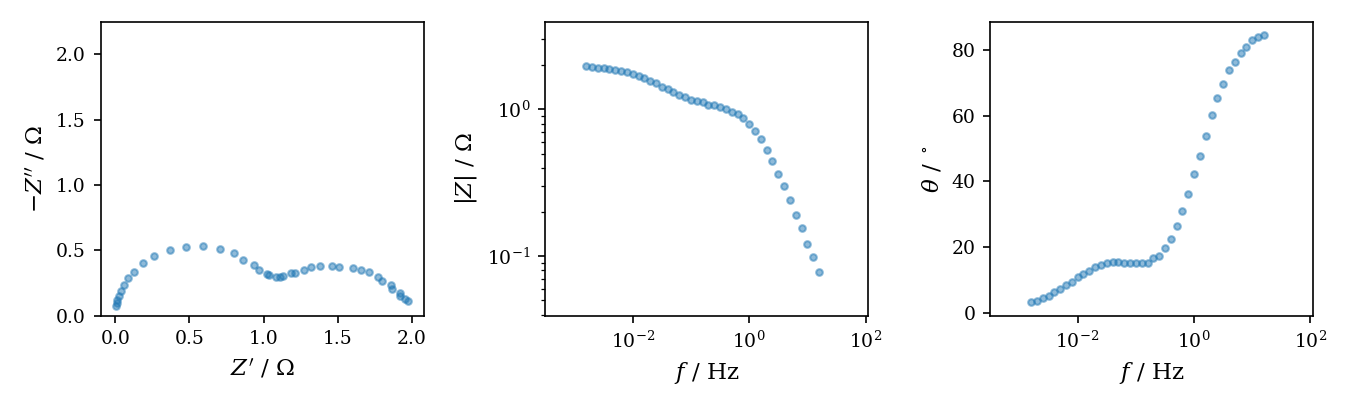

In [89]:
# Load 2nd simulated dataset
df_sim2 = pd.read_csv(os.path.join(datadir,'simulated','Z_RC-ZARC_Macdonald_0.25.csv'))
freq_sim2, Z_sim2 = fl.get_fZ(df_sim2)

# Load true DRT
g_true2 = pd.read_csv(os.path.join(datadir,'simulated','gamma_RC-ZARC.csv'))

# Plot data
axes = bp.plot_eis(df_sim2)

In [99]:
# For convenience, create separate instances for the unbounded and non-negative fits
inv_unbnd = Inverter()
inv_nonneg = Inverter()

# Fit without constraint
start = time.time()
inv_unbnd.fit(freq_sim2, Z_sim2)
print('Fit time (no constraint): {:.2f} s'.format(time.time() - start))

# Fit with constraint
start = time.time()
inv_nonneg.fit(freq_sim2, Z_sim2, nonneg=True)
print('Fit time (non-negative): {:.2f} s'.format(time.time() - start))

Fit time (no constraint): 3.02 s
Fit time (non-negative): 1.07 s


The constrained fit runs substantially faster than the unconstrained fit.

<IPython.core.display.Javascript object>


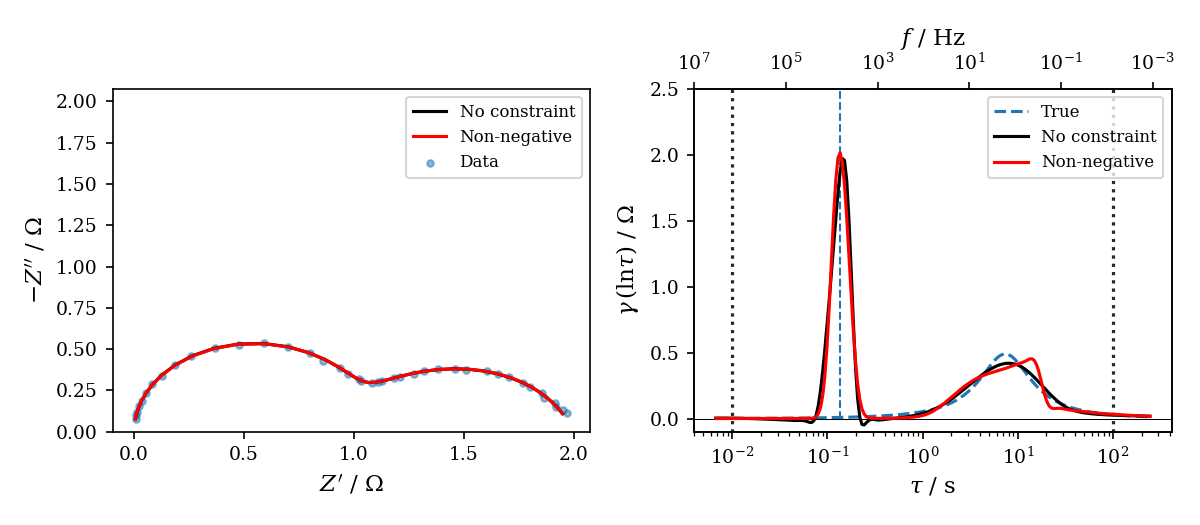

In [105]:
"Compare fits"
# plot impedance fit and recovered DRT
fig,axes = plt.subplots(1, 2, figsize=(8, 3.5))

# plot fits of impedance data
inv_unbnd.plot_fit(axes=axes[0], plot_type='nyquist', color='k', label='No constraint', data_label='Data')
inv_nonneg.plot_fit(axes=axes[0], plot_type='nyquist', color='r', label='Non-negative', plot_data=False)

# plot true DRT
p = axes[1].plot(g_true2['tau'], g_true2['gamma'], label='True', ls='--')
# add Dirac delta function for RC element
axes[1].plot([np.exp(-2), np.exp(-2)], [0, 10], ls='--', c=p[0].get_color(), lw=1)

# Plot recovered DRT at given tau values
tau_plot = g_true2['tau'].values
inv_unbnd.plot_distribution(ax=axes[1], tau_plot=tau_plot, color='k', label='No constraint')
inv_nonneg.plot_distribution(ax=axes[1], tau_plot=tau_plot, color='r', label='Non-negative')

axes[1].set_ylim(-0.1, 2.5)
axes[1].legend(loc='upper right')

fig.tight_layout()

Both fits recover the sharp RC peak at $\tau \approx 0.13$ s fairly well, but the non-negative fit results in a distorted peak for the ZARC element at $\tau \approx 7$ s.  The unconstrained fit does create small negative pseudo-peaks on either side of the RC peak due to the sharpness of the peak, but these are small enough that they can reasonably easily be recognized as pseudo-peaks. 

This is an example of a case where the bound at zero causes unexpected behavior in the optimizer. This can be addressed by initializing the model from a fast ridge solution, as described in Section 3 below.

## 2b. DRT with positive and negative peaks
For this example, we use data collected from an electrolysis cell under bias. There is a negative impedance arc at low frequency, which can be represented with a negative DRT peak.

<IPython.core.display.Javascript object>


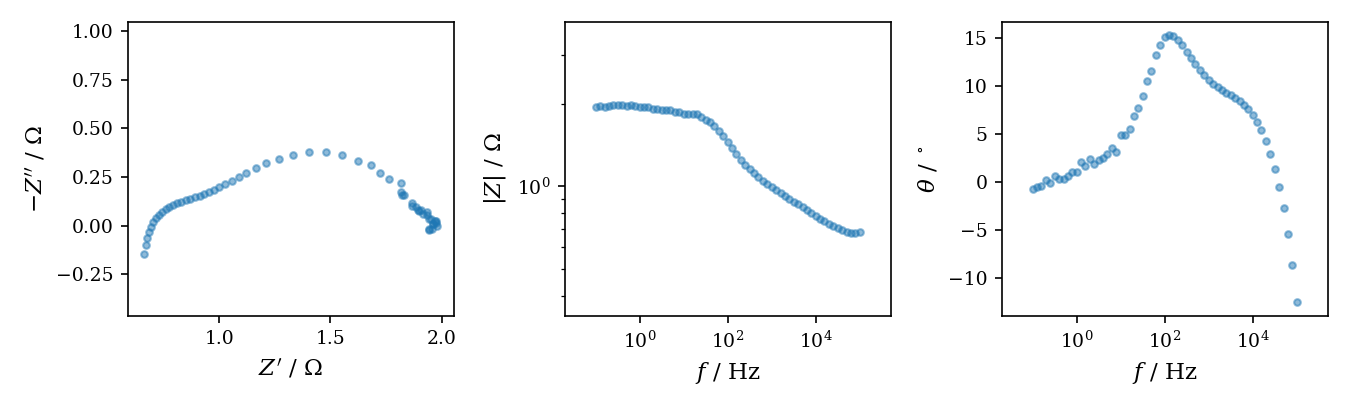

In [108]:
# Load 2nd experimental dataset
df_exp2 = fl.read_eis(os.path.join(datadir, 'experimental', '550C.0.5V.DTA'))

# Extract frequencies and impedance
freq_exp2, Z_exp2 = fl.get_fZ(df_exp2)

# Plot experimental data
axes = bp.plot_eis(df_exp2)

In the Nyquist and Bode plots, the small negative loop at low frequency is visible.

Fit time (no constraint): 4.31 s


c:\users\jdh10\onedrive - colorado school of mines\python\projects\bayes_drt\bayes_drt\inversion.py:1289: UserWarning: Possible outliers were identified at indices [[40]], f=[[9.91015]] Hz. Check the residuals and consider re-running with outliers=True
  outlier_idx, frequencies[outlier_idx]))


<IPython.core.display.Javascript object>


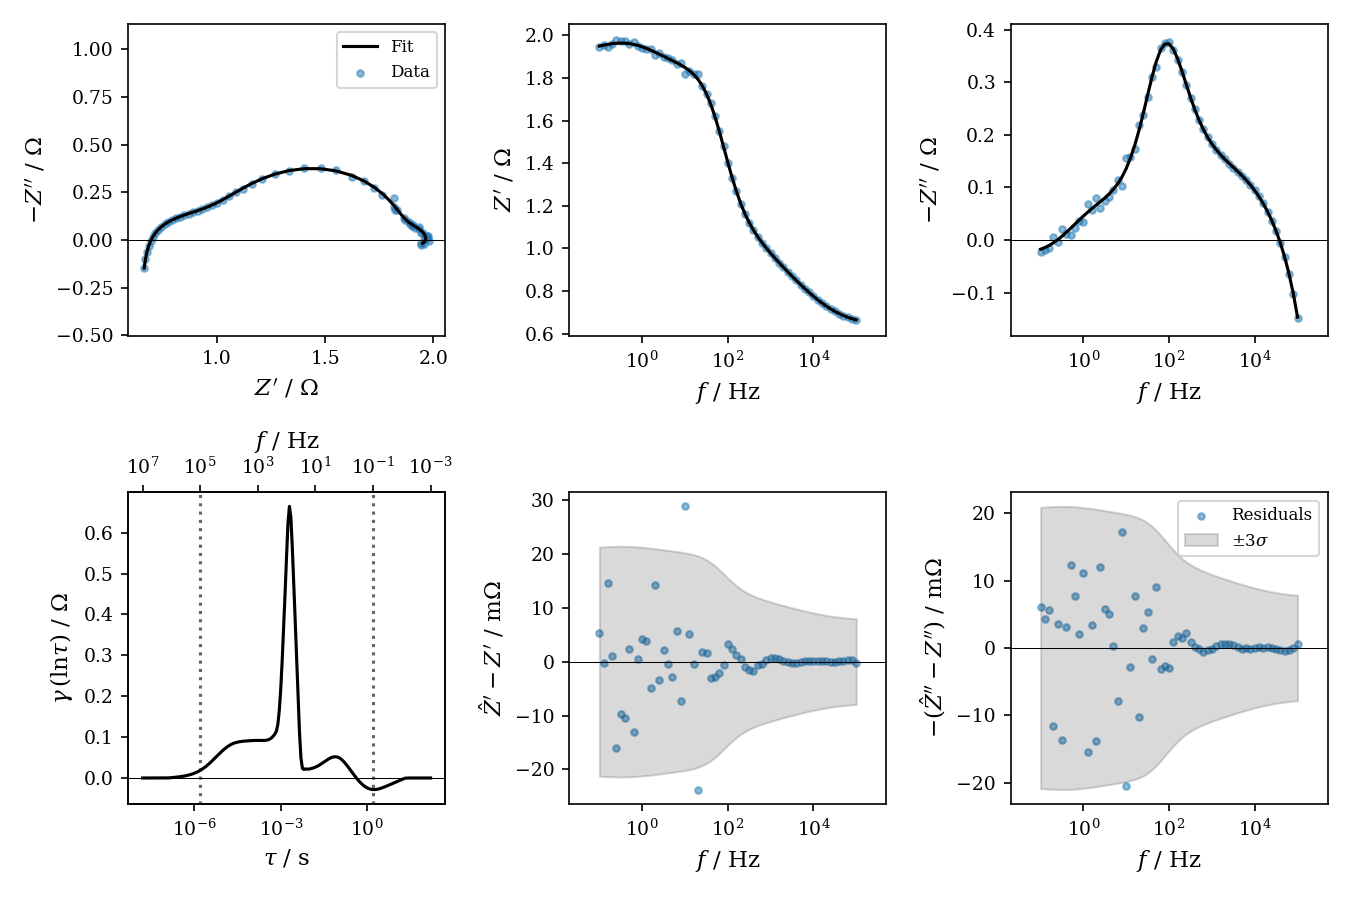

In [107]:
# Fit without constraint
start = time.time()
inv_unbnd.fit(freq_exp2, Z_exp2)
print('Fit time (no constraint): {:.2f} s'.format(time.time() - start))

# Plot results
axes = inv_unbnd.plot_full_results()

The negative loop is described well by a small negative peak in the DRT at $\tau \approx 1$ s. Note that the `Inverter` also delivers a warning that there may be an outlier (corrupted data point) at 10 Hz. This detection system can be employed to automatically trigger the use of an outlier-robust error model when necessary, as described further in the Outliers tutorial.

Fit time (non-negative): 3.23 s


<IPython.core.display.Javascript object>


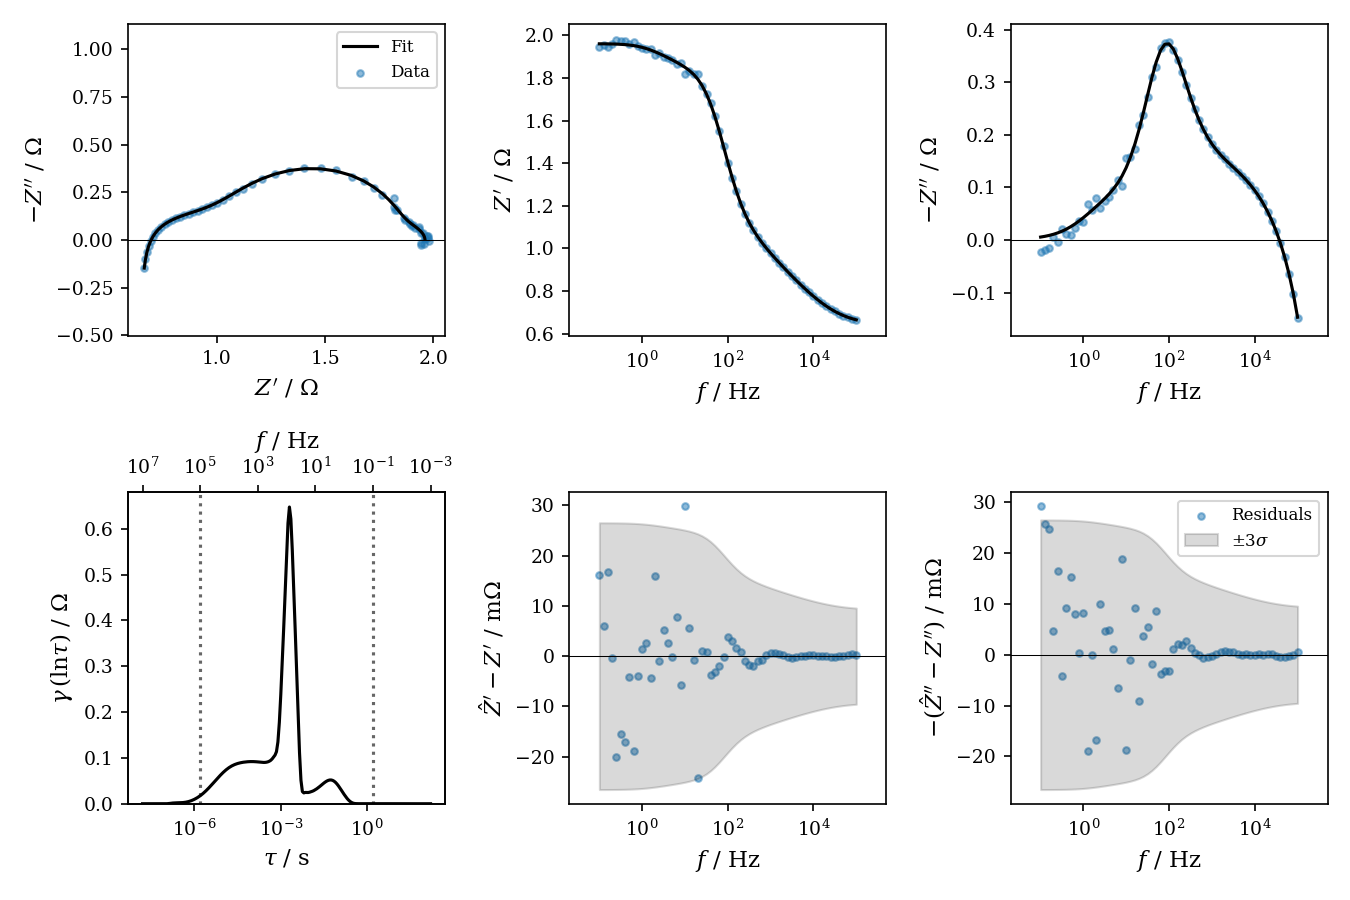

In [109]:
# Fit with constraint
start = time.time()
inv_nonneg.fit(freq_exp2, Z_exp2, nonneg=True)
print('Fit time (non-negative): {:.2f} s'.format(time.time() - start))

# Plot results
axes = inv_nonneg.plot_full_results()

When the DRT is constrained to non-negative values, the low-frequency portion of the spectrum cannot be fitted properly. This leads to an inflated estimate of the error at low frequencies, which also causes the outlier detection system to miss the likely outlier at 10 Hz. Thus, in this case the DRT must be allowed to take on negative values in order to properly fit the data.

# 3. Model initialization
When a DRT fit is performed, the model parameters are evolved from some initial state to a final, (hopefully) optimal state. Since the optimization is non-linear and local minima exist, the initial parameter values can affect the final values - a good initial "guess" for the parameters can help the optimizer converge to the global minimum, while a bad initial guess may result in the optimizer finding a local minimum rather than the global minimum. 

By default, the `fit` method uses (semi-)random initial parameter values. This usually works well, but in some cases (such as the example in Section 2a) providing a decent initial guess can improve the final fit and/or increase the speed of convergence. This is demonstrated below using the same dataset used in Section 2a.

In [124]:
# Use default basis
inv_rand = Inverter()
inv_ridge = Inverter()

# Fit with random intialization
start = time.time()
inv_rand.fit(freq_sim2, Z_sim2, nonneg=True)
print('Fit time (random initialization): {:.2f} s'.format(time.time() - start))

# Fit with ridge intialization
start = time.time()
inv_ridge.fit(freq_sim2, Z_sim2, nonneg=True, init_from_ridge=True)
print('Fit time (ridge initialization): {:.2f} s'.format(time.time() - start))

Fit time (random initialization): 1.07 s
Fit time (ridge initialization): 2.07 s


The fit with ridge initialization takes slightly longer to run in this case; this is because the fit with random initialization quickly converges to a local minimum, while the ridge-initialized fit finds the global minimum.

<IPython.core.display.Javascript object>


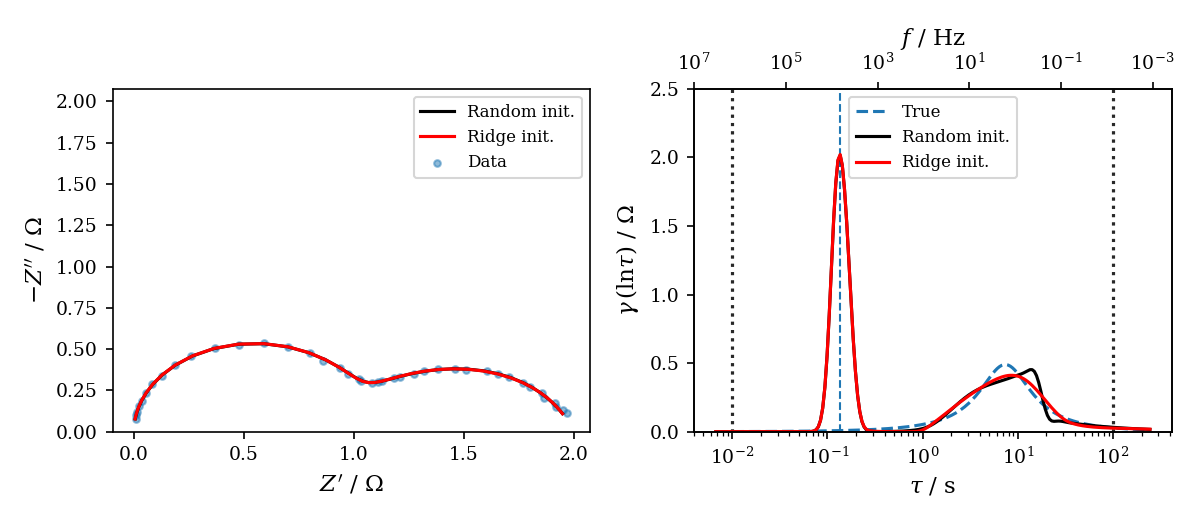

In [125]:
"Compare fits"
# plot impedance fit and recovered DRT
fig,axes = plt.subplots(1, 2, figsize=(8, 3.5))

# plot fits of impedance data
inv_rand.plot_fit(axes=axes[0], plot_type='nyquist', color='k', label='Random init.', data_label='Data')
inv_ridge.plot_fit(axes=axes[0], plot_type='nyquist', color='r', label='Ridge init.', plot_data=False)

# plot true DRT
p = axes[1].plot(g_true2['tau'],g_true2['gamma'],label='True',ls='--')
# add Dirac delta function for RC element
axes[1].plot([np.exp(-2),np.exp(-2)],[0,10],ls='--',c=p[0].get_color(),lw=1)

# Plot recovered DRT at given tau values
tau_plot = g_true2['tau'].values
inv_rand.plot_distribution(ax=axes[1], tau_plot=tau_plot, color='k', label='Random init.')
inv_ridge.plot_distribution(ax=axes[1], tau_plot=tau_plot, color='r', label='Ridge init.')

axes[1].set_ylim(0,2.5)
axes[1].legend()

fig.tight_layout()

Random initialization results in the optimizer finding a local minimum represented by the distorted fit in black. Ridge initialization helps the optimizer avoid this suboptimal solution and find a smoother solution closer to the global optimum, represented by the red line. **In general, using `ridge_init=True` will give you the most consistent results, but it can in rare cases result in a worse final fit than random initialization. If you are having trouble fitting a spectrum, try running with `ridge_init=True` and `ridge_init=False` and compare the results.**

If you are curious what the initial ridge solution looks like, you can run `ridge_fit` with `preset='Huang'` to obtain the ridge solution used to initialize the CHB fit.

Initial ridge fit time: 0.07 s


<IPython.core.display.Javascript object>


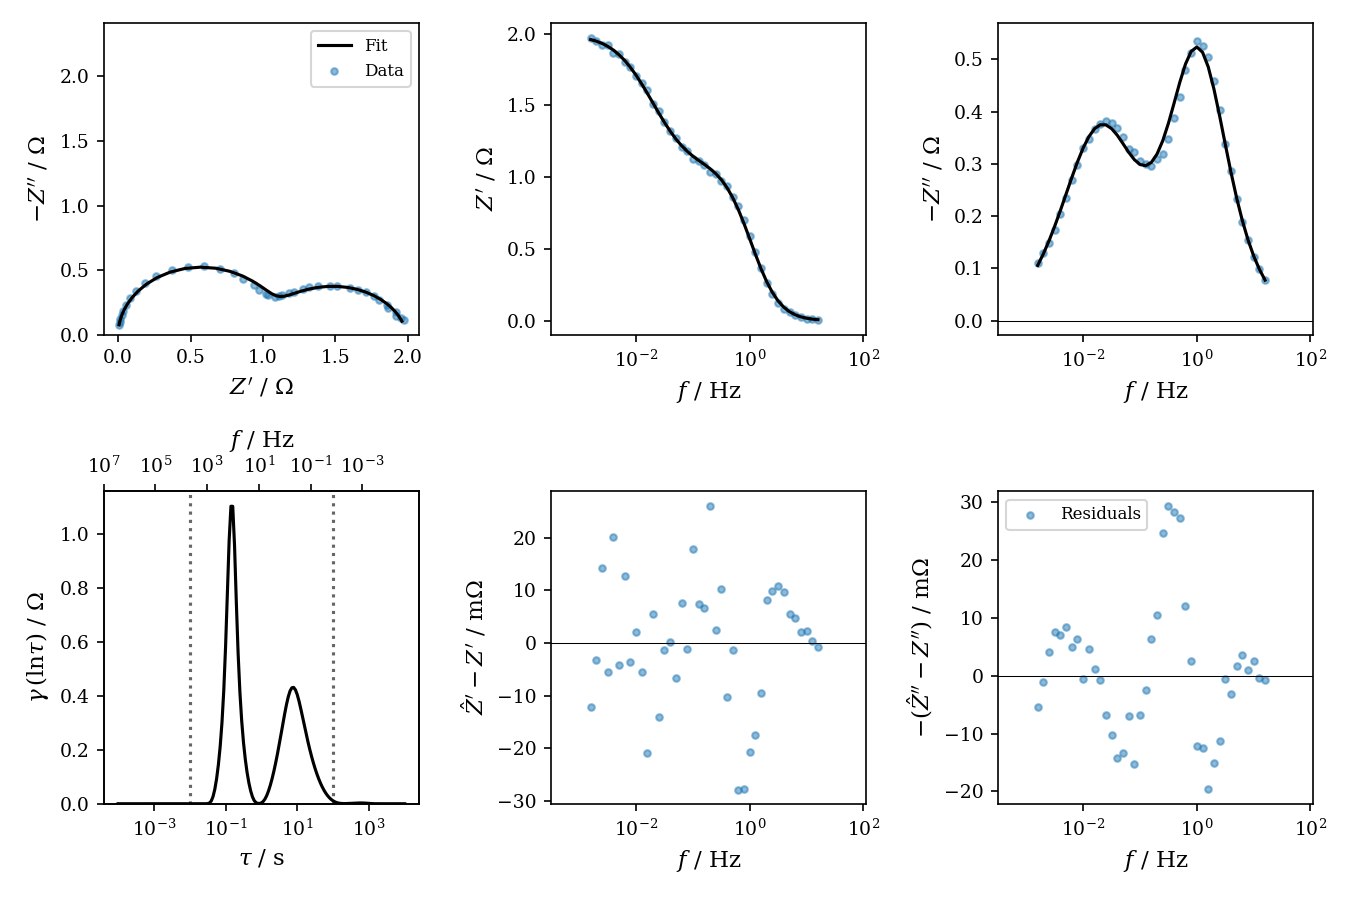

In [126]:
# Show initial ridge solution
start = time.time()
inv_ridge.ridge_fit(freq_sim2, Z_sim2, preset='Huang', nonneg=True)
print('Initial ridge fit time: {:.2f} s'.format(time.time() - start))

axes = inv_ridge.plot_full_results()

The initial ridge solution is over-smoothed, but provides a decent starting point for the CHB fit with very little computational cost.